In [4]:
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using Plots
using Random
using AbstractAlgebra
using LaTeXStrings
using Quantikz: displaycircuit

# States of interest

All of the states will be expressed in one of the many canonical forms available, so that comparisons can be performed easily.

A typical Bell pair

In [5]:
good_bell_state = S"XX
                    ZZ"
canonicalize_rref!(good_bell_state)[1]

+ ZZ
+ XX

In [27]:
N=3
MAX_OPS=8
prob=0.25

0.25

In [7]:
function state_tensor_pow(state::Stabilizer{Vector{UInt8}, Matrix{UInt64}},power::Integer)
    result=state
    for i in 1:power-1
        result=result⊗state
    end
    return result
end

state_tensor_pow (generic function with 1 method)

## Generate random circuits

In [72]:
function ApplyRandGates(circuit,rand1,rand2,rand3,current,qNum,qList,cnotList,cphaseList,measured)
    #pick a random pair from currently available qubits
    n=Int(length(current)/2)
    a=Int(floor(rand()*n))*2+1
    b=Int(floor(rand()*n))*2+1
    while a==b
        b=Int(floor(rand()*n))*2+1
    end
    pair=[current[a],current[b]]
    #probability of applying controlled phase gate
    if rand1>prob && rand1<prob*2 
        #it is enough to keep track of only the Alice side of qubits
        #either the control qubit is preserved qubit or that it has been a targe bit with preserved qubit as the control
        if pair[1]==1 || (qList[pair[1]]==1 && pair[2]!=1)
            #remove redundant gates
            #do not apply the same controlled gate twice
            if cphaseList[pair[2]]!=pair[1]
                circuit=append!(circuit,[SparseGate(CPHASE, pair)])
                circuit=append!(circuit,[SparseGate(CPHASE, [pair[1]+1,pair[2]+1])])
                qList[pair[2]]=1
                cphaseList[pair[2]]=pair[1]
                cphaseList[pair[1]]=pair[2]
            end
        elseif pair[2]==1 || (qList[pair[2]]==1 && pair[1]!=1)
            if cphaseList[pair[1]]!=pair[2]
                circuit=append!(circuit,[SparseGate(CPHASE, pair)])
                circuit=append!(circuit,[SparseGate(CPHASE, [pair[1]+1,pair[2]+1])])
                qList[pair[1]]=1
                cphaseList[pair[1]]=pair[2]
                cphaseList[pair[2]]=pair[1]
            end
        end
    #probability of applying controlled not gate
    #preserved qubits can never be the target qubits
    elseif rand1>=prob*2 && rand1<prob*3
        if pair[2]==1
            if cnotList[pair[1]]!=pair[2]
                circuit=append!(circuit,[SparseGate(CNOT, [pair[2],pair[1]])])
                circuit=append!(circuit,[SparseGate(CNOT, [pair[2]+1,pair[1]+1])])
                qList[pair[1]]=1
                cnotList[pair[1]]=pair[2]
            end
        elseif pair[1]==1 || (qList[pair[1]]==1 && pair[2]!=1)
            if cnotList[pair[2]]!=pair[1]
                circuit=append!(circuit,[SparseGate(CNOT, pair)])
                circuit=append!(circuit,[SparseGate(CNOT, [pair[1]+1,pair[2]+1])])
                qList[pair[2]]=1
                cnotList[pair[2]]=pair[1]
            end
        end
    else 
    #equal opportunities of measurement for coinX, coinZ, or antiY
        measurement=[X,Y,Z][Int(floor(rand2*3))+1]
#         measurement=[X,Z][Int(floor(rand2*2))+1]
        qubit=pair[Int(floor(rand2*2))+1]
        if qubit==1
            if qubit==pair[1]
                qubit=pair[2]
            else
                qubit=pair[1]
            end
        end
        if qList[qubit]==1
            circuit=append!(circuit,[BellMeasurement([measurement,measurement],[qubit,qubit+1])])
            measured=append!(measured,[qubit,qubit+1])
            qList[qubit]=0
            #remove the measured pairs from the current qubit list
            filter!(e->e∉[qubit,qubit+1],current)
            #create new qubits if the qubits have been measured
            qNum[1]=qNum[1]+1
            current=append!(current,[qNum[1]*2-1,qNum[1]*2])
            qList=append!(qList,[0,0])
            cnotList=append!(cnotList,[0,0])
            cphaseList=append!(cphaseList,[0,0])
        end
     end
end

ApplyRandGates (generic function with 3 methods)

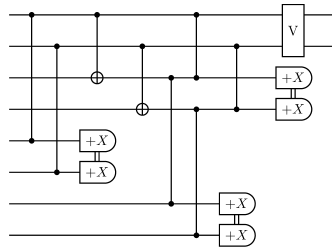

In [77]:
circuit=[]
#keep track of trash qubits that are measured
measured=[]
#list of currently available qubits
current=[i for i in 1:N*2]
#qList keeps track of whether any controlled gates (with preserved qubits as controls) have been applied to each qubit
qList=[0 for i in 1:N*2]
cnotList=[0 for i in 1:N*2]
cphaseList=[0 for i in 1:N*2]
#track how many qubits are used in total
qNum=[N]
for opt in 1:MAX_OPS
    #equal probabilities of applying nothing, CPHASE, CNOT, measurement (coinX, coinZ, antiY) (what are the permitted gates)
    ApplyRandGates(circuit,rand(),rand(),rand(),current,qNum,qList,cnotList,cphaseList,measured)
end
# Add measurement to all trash qubits that are not measured
for i in 1:length(qList)
    if qList[i]!=0
        measurement=[X,Y,Z][Int(floor(rand()*3))+1]
        circuit=append!(circuit,[BellMeasurement([measurement,measurement],[i,i+1])])
        measured=append!(measured,[i,i+1])
    end
end
#remove unused qubit pairs
n=Int(maximum(measured)/2)
initial_state=state_tensor_pow(good_bell_state,n)

circuit=append!(circuit,[VerifyOp(good_bell_state, [1,2])])
displaycircuit(circuit)

#TODO: removing redundant gates,method: maintain a dictionary {qubit:CNOT_qubit,CPAHSE_qubit} or maintain two list, 
#at each entry is the qubit number of the controlled qubit if any

We can run a Monte Carlo simulation with `mctrajectories`, or a Perturbative Expansion calculation with `petrajectories`. Given that there is no noise source in this circuit, all Monte Carlo samples will give the same result.

In [78]:
petrajectories(initial_state, circuit)

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.0
  :detected_failure   => 0.0
  :true_success       => 1.0

In [79]:
mctrajectories(initial_state, circuit, trajectories=100)

Dict{Symbol, Int64} with 3 entries:
  :undetected_failure => 0
  :detected_failure   => 0
  :true_success       => 100

The possible final statuses (`:undetected_failure`, `:detected_failure`, `:true_success`) come from the definitions of the various circuit operations. `SparseGate` always generates `:continue`, which tells the simulator to continue to the next operation. `BellMeasurement` can report `:detected_failure` or `:continue`, depending whether there was an anti-coincidence or a coincidence. Finally `VerifyOp` reports either `:true_success` if we indeed obtained the desired state, or a `:undetected_failure` if the obtained state is not the desired one even though the measurement step had reported `:continue`. Custom statuses can be implemented as well, as seen later on.

Later on we will also need to compare these results against no purification so we define this circuit for convenience:

In [197]:
nopurification_circuit = [VerifyOp(good_bell_state, [1,2])];

## Define a network noise parameter to be used for the rest of the notebook

For a more interesting calculation, we will now introduce network noise with the `NoiseOpAll` operation, which causes depolarization of certain strength to all of the qubits.

In [198]:
netnoise_value = 0.10
one_third_netnoise = netnoise_value/3 # The probability for X, Y, or Z error
netnoise = UnbiasedUncorrelatedNoise(one_third_netnoise)
netnoise_opall = NoiseOpAll(netnoise);

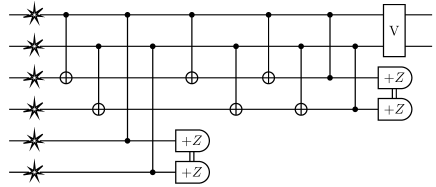

In [199]:
displaycircuit([netnoise_opall,circuit...]) # The explosions denote depolarization noise

In [200]:
pe_netnoise = petrajectories(initial_state, [netnoise_opall,circuit...])

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.078732
  :detected_failure   => 0.236196
  :true_success       => 0.570807

In [202]:
pe_netnoise_nopurification = petrajectories(good_bell_state,
                                            [netnoise_opall,nopurification_circuit...],max_order=2)

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.186667
  :detected_failure   => 0.0
  :true_success       => 0.813333

In [206]:
latexstring("""
    Therefore a network depolarization rate of $(3*one_third_netnoise)
    causes the fidelity to drop to
    \$F_{0}=
    $(round(pe_netnoise_nopurification[:true_success],digits=3))
    \$.
    But purification can increase the fidelity to
    \$\\frac{\\mathrm{true\\ success}}{\\mathrm{true\\ success}+\\mathrm{undetected\\ failure}}=
    $(round(pe_netnoise[:true_success] / (pe_netnoise[:true_success]+pe_netnoise[:undetected_failure]),digits=3))
    \$.
    With a rate of positive coincidence measurements of
    \$\\mathrm{true\\ success}+\\mathrm{undetected\\ failure}=
    $(round(pe_netnoise[:true_success]+pe_netnoise[:undetected_failure],digits=3))
    \$.
    """)

L"Therefore a network depolarization rate of 0.1
causes the fidelity to drop to
$F_{0}=
0.813
$.
But purification can increase the fidelity to
$\frac{\mathrm{true\ success}}{\mathrm{true\ success}+\mathrm{undetected\ failure}}=
0.879
$.
With a rate of positive coincidence measurements of
$\mathrm{true\ success}+\mathrm{undetected\ failure}=
0.65
$.
"

### Monte Carlo instead of Perturbative Expansions

The 10% network error rate we have picked is not all that small, and the perturbative expansion will not be all that accurate. We can attempt Monte Carlo simulations. For very large circuits this would be cheaper than perturbative expansions. Choosing the best method is a balancing act that depends on the desired accuracy, the size of the circuit, and the number of noisy components.

In [207]:
mc_netnoise = mctrajectories(initial_state, [netnoise_opall,circuit...],
                             trajectories=10000)

Dict{Symbol, Int64} with 3 entries:
  :undetected_failure => 1044
  :detected_failure   => 3110
  :true_success       => 5846

### Symbolic Perturbative Expansions

The perturbative expansions can be done with any of the available symbolic libraries under Julia (including the Julia interface to the SymPy Python library). Here we give an example with `AbstractAlgebra.jl`, part of Nemo. Fractions are a bit clunky, so we treat the numerator and denominator separately. `SymPy` would be simpler to use, but it can be a bit slower.

We will define two symbols, one for the network noise, and one for the gate noise to be used later.

In [72]:
using AbstractAlgebra
field = RealField # If you want to use multiprecision floats
# field = QQ # If you want to use rationals
R, (e_netn, e_gate) = PolynomialRing(field, ["e_n", "e_g"],
                                     ordering=:deglex)
sym_unity = R(1);

In [73]:
typeof(e_netn)

AbstractAlgebra.Generic.MPoly{BigFloat}

In [74]:
sym_netnoise = UnbiasedUncorrelatedNoise(1//3*e_netn)
sym_netnoise_opall = NoiseOpAll(sym_netnoise);

In [75]:
sym_pe_netnoise = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                             branch_weight=sym_unity)

sym_true_success = sym_pe_netnoise[:true_success]
sym_coincidence_prob = (sym_pe_netnoise[:true_success]+sym_pe_netnoise[:undetected_failure]);

We can print out the symbolic expression:

In [76]:
latexstring(sym_true_success)

L"$0$"

And evaluate it to compare it with the numerical calculation:

In [77]:
sym_true_success(netnoise_value, 0) # evaluate at e_n = netnoise_value, e_g = 0

0.0

In [78]:
pe_netnoise[:true_success]

0.0

### Higher order expansions

Higher order expansions are also possible with this library, however the cost of the simulation grows exponentially in the order, due to the combinatorial explosion of trajectories that need to be followed. See the example below where we see the number of branches for the depolarization acting on all qubits.

In [79]:
for order in [0,1,2,3,4]
    branches = applynoise_branches(initial_state, netnoise, [1,2,3,4], max_order=order)
    println((order = order, nb_of_branches = length(branches), total_probability = sum(b[2] for b in branches)))
end

(order = 0, nb_of_branches = 1, total_probability = 0.6561)
(order = 1, nb_of_branches = 13, total_probability = 0.9476999999999999)
(order = 2, nb_of_branches = 67, total_probability = 0.9963000000000005)
(order = 3, nb_of_branches = 175, total_probability = 0.9999000000000001)
(order = 4, nb_of_branches = 256, total_probability = 1.0000000000000007)


Let us compute the whole circuits to the given order

In [26]:
@time sym_pe_netnoise2 = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                                  branch_weight=sym_unity, max_order=2);
@time sym_pe_netnoise3 = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                                  branch_weight=sym_unity, max_order=3);
@time sym_pe_netnoise4 = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                                  branch_weight=sym_unity, max_order=4);

  0.024467 seconds (56.90 k allocations: 2.959 MiB, 68.14% compilation time)
  0.013504 seconds (116.61 k allocations: 5.809 MiB)
  0.018235 seconds (165.62 k allocations: 8.270 MiB)


### All of the results together

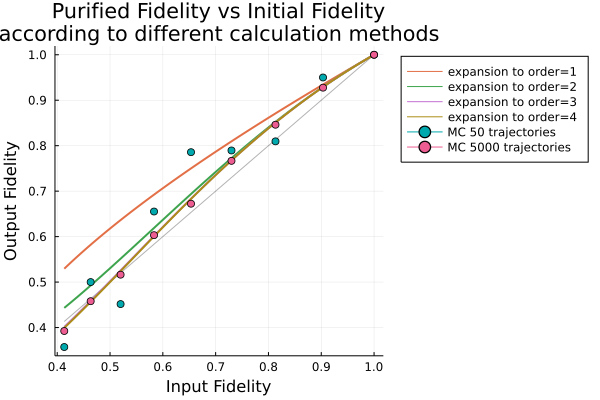

In [27]:
plot(title="Purified Fidelity vs Initial Fidelity\naccording to different calculation methods")

netnoise_pe_samples = 0.0:0.005:0.4
netnoise_mc_samples = 0.0:0.05:0.4
mc_trajectories = [50, 5000]

# No purification
exact_solution_no_purification = petrajectories(good_bell_state,
                                                [sym_netnoise_opall,nopurification_circuit...],
                                                branch_weight=sym_unity,
                                                max_order=100)
F0 = exact_solution_no_purification[:true_success].(netnoise_pe_samples,0)
plot!(F0,F0,color=:black,alpha=0.3,label=false)

# Symbolic perturbative expansions
for (order,sym_result) in enumerate(
        [sym_pe_netnoise,sym_pe_netnoise2,sym_pe_netnoise3,sym_pe_netnoise4])
    ts = sym_result[:true_success].(netnoise_pe_samples, 0)
    uf = sym_result[:undetected_failure].(netnoise_pe_samples, 0)
    Fout = ts ./ (ts .+ uf)
    plot!(F0, Fout, label="expansion to order=$(order)", lw=2)
end

# Monte Carlo approach
F0 = exact_solution_no_purification[:true_success].(netnoise_mc_samples,0)
for m in mc_trajectories
    Fout_mc = []
    for n in netnoise_mc_samples
        one_third_netnoise = n/3 # The probability for X, Y, or Z error
        netnoise = UnbiasedUncorrelatedNoise(one_third_netnoise)
        netnoise_opall = NoiseOpAll(netnoise)
        mc_netnoise = mctrajectories(initial_state, [netnoise_opall,circuit...],
                                     trajectories=m)
        push!(Fout_mc, mc_netnoise[:true_success]/(mc_netnoise[:true_success]+mc_netnoise[:undetected_failure]))
    end
    plot!(F0, Fout_mc, label="MC $(m) trajectories", line=false, marker=true)
end      

plot!(legend=:outertopright, xlabel="Input Fidelity", ylabel="Output Fidelity")

## Local Operational Noise in Addition to the Network Noise

Up to here we considered imperfect initial states purified by perfect circuits. Now we will introduce imperfect gates as well, and study a few different regimes of the gate error model. We will add a small chance of depolarization to all of the gates and a chance for flipping a qubit to all measurements.

In [12]:
# A helper function to add noise to ops and lists of ops.
make_noisy(g::SparseGate, noise) = NoisyGate(g, UnbiasedUncorrelatedNoise(1//3*noise))
make_noisy(m::BellMeasurement, noise) = NoisyBellMeasurement(m, noise)
make_noisy(other_op, noise) = other_op
make_noisy(circuit::AbstractVector, noise) = [make_noisy(op, noise) for op in circuit];

In [16]:
sym_pe_allnoise = petrajectories(
    initial_state,
    [sym_netnoise_opall,make_noisy(circuit, e_gate)...],
    branch_weight=sym_unity)

sym_true_success = sym_pe_allnoise[:true_success]
sym_coincidence_prob = (sym_pe_allnoise[:true_success]+sym_pe_allnoise[:undetected_failure]);

LoadError: UndefVarError: p not defined

In [29]:
latexstring(sym_true_success) # Not all that legible # TODO print this better

L"$2.0*e_n^4*e_g^6 + -10.0*e_n^4*e_g^5 + -8.0*e_n^3*e_g^6 + 20.33333333333333333333333333333333333333333333333333333333333333333333333333315*e_n^4*e_g^4 + 40.0*e_n^3*e_g^5 + 12.0*e_n^2*e_g^6 + -22.0*e_n^4*e_g^3 + -81.3333333333333333333333333333333333333333333333333333333333333333333333333326*e_n^3*e_g^4 + -60.0*e_n^2*e_g^5 + -8.0*e_n*e_g^6 + 14.0*e_n^4*e_g^2 + 88.0*e_n^3*e_g^3 + 122.0*e_n^2*e_g^4 + 40.0*e_n*e_g^5 + 2.0*e_g^6 + -5.333333333333333333333333333333333333333333333333333333333333333333333333333287*e_n^4*e_g + -56.0*e_n^3*e_g^2 + -132.0*e_n^2*e_g^3 + -81.3333333333333333333333333333333333333333333333333333333333333333333333333326*e_n*e_g^4 + -10.0*e_g^5 + 1.0*e_n^4 + 21.33333333333333333333333333333333333333333333333333333333333333333333333333315*e_n^3*e_g + 84.0*e_n^2*e_g^2 + 88.0*e_n*e_g^3 + 20.33333333333333333333333333333333333333333333333333333333333333333333333333315*e_g^4 + -4.0*e_n^3 + -32.0*e_n^2*e_g + -56.0*e_n*e_g^2 + -22.0*e_g^3 + 6.0*e_n^2 + 21.333333333333333333

In [27]:
sym_allnoise_circuit = [sym_netnoise_opall,make_noisy(circuit, e_gate)...];

In [28]:
@time sym_pe_allnoise2 = petrajectories(
    initial_state,
    sym_allnoise_circuit,
    branch_weight=sym_unity,
    max_order=2);

  0.085509 seconds (332.54 k allocations: 17.341 MiB)


In [29]:
@time sym_pe_allnoise3 = petrajectories(
    initial_state,
    sym_allnoise_circuit,
    branch_weight=sym_unity,
    max_order=3);

  0.435324 seconds (1.95 M allocations: 100.066 MiB, 9.99% gc time)


In [30]:
@time sym_pe_allnoise4 = petrajectories(
    initial_state,
    sym_allnoise_circuit,
    branch_weight=sym_unity,
    max_order=4);

  1.741999 seconds (7.68 M allocations: 389.640 MiB, 14.31% gc time)


### All of the noisy circuit results together

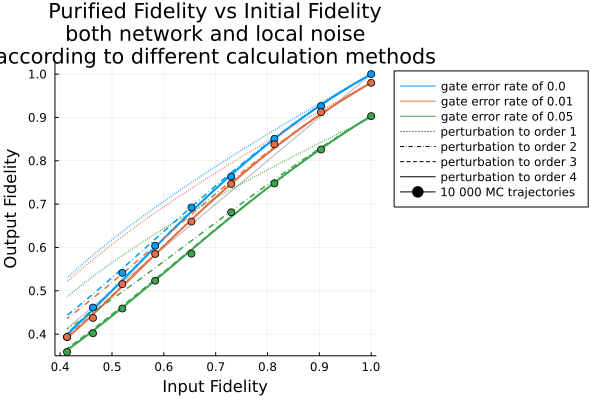

In [31]:
plot(title="Purified Fidelity vs Initial Fidelity\nboth network and local noise\naccording to different calculation methods")

netnoise_pe_samples = 0.0:0.005:0.4
netnoise_mc_samples = 0.0:0.05:0.4
local_noise_samples = [0.0, 0.01, 0.05]
mc_trajectories = 10000

line_styles = [:dot, :dashdot, :dash, :solid]

# No purification
exact_solution_no_purification = petrajectories(good_bell_state,
                                                [sym_netnoise_opall,nopurification_circuit...],
                                                branch_weight=sym_unity,
                                                max_order=100)
F0 = exact_solution_no_purification[:true_success].(netnoise_pe_samples,0)
plot!(F0,F0,color=:black,alpha=0.3,label=false)

# Symbolic perturbative expansions
for (li, local_noise) in enumerate(local_noise_samples)
    for (order,sym_result) in enumerate(
            [sym_pe_allnoise,sym_pe_allnoise2,sym_pe_allnoise3,sym_pe_allnoise4])
        ts = sym_result[:true_success].(netnoise_pe_samples, local_noise)
        uf = sym_result[:undetected_failure].(netnoise_pe_samples, local_noise)
        Fout = ts ./ (ts .+ uf)
        plot!(F0, Fout,
            label = order==4 ? "gate error rate of $(local_noise)" : nothing,
            lw = order==4 ? 2 : 1.5,
            color=li, linestyle=line_styles[order],
        )
    end
end

    
# Monte Carlo approach
F0 = exact_solution_no_purification[:true_success].(netnoise_mc_samples,0)
for (li, local_noise) in enumerate(local_noise_samples)
    Fout_mc = []
    for n in netnoise_mc_samples
        one_third_netnoise = n/3 # The probability for X, Y, or Z error
        netnoise = UnbiasedUncorrelatedNoise(one_third_netnoise)
        netnoise_opall = NoiseOpAll(netnoise)
        c = [netnoise_opall,circuit...]
        c = make_noisy(c, local_noise)
        mc_netnoise = mctrajectories(initial_state, c,
                                     trajectories=mc_trajectories)
        push!(Fout_mc, mc_netnoise[:true_success]/(mc_netnoise[:true_success]+mc_netnoise[:undetected_failure]))
    end
    plot!(F0, Fout_mc, label=nothing, line=false, marker=true, color=li)
end

# Legend
for (li, style) in enumerate(line_styles)
    plot!([-1], [-1], linestyle = style, label = "perturbation to order $(li)", color = "black")
end
plot!([-1], [-1], line=false, marker=true, label = "10 000 MC trajectories", color = "black")
plot!(xlim=(0.39,1.01))
plot!(ylim=(0.35,1.03))
plot!(legend=:outertopright, xlabel="Input Fidelity", ylabel="Output Fidelity")